# GOAL OF THE PROJECT

**`Predict target feature first and foremost by geometrical parameters`**

# IMPORTING LIBRARIES

In [634]:
import pandas as pd
pd.options.display.max_columns = None
pd.options.display.float_format = '{:.2f}'.format
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import cm as cmaps
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import datetime as dt
import re
import seaborn as sns
from scipy import stats
import random
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import quantile_transform
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import OneHotEncoder  ##. better to use dummy from pandas 
from sklearn.preprocessing import PowerTransformer
from scipy.stats import boxcox
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from scipy.stats import boxcox
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

print("Packages loaded!")

Packages loaded!


# Pipeline Controller

df = load_original_data()
df_cleaned = delete_unncessary_columns(df)
df_cleaned = make_columns_lowercase(df_cleaned)
df_cleaned = delete_non_legit_XDC_IDs(df_cleaned)
df_cleaned, date_columns = date_columns_transform_into_datetime(df_cleaned)
df_cleaned = delete_rows_with_nan_in_selected_cols(df_cleaned, ["schmelzen_datum", "ns1_datum"])
df_cleaned = substitute_familie_int_str(df_cleaned)
df_cleaned = add_date_month_string_columns(df_cleaned, date_columns)
df_cleaned = string_comma_to_dot_float(df_cleaned)
#df_cleaned = clean_personal_names(df_cleaned)

# READ DATA INTO DATAFRAME FROM EXISTING .CSV

In [635]:
def load_original_data():
    """
    Read production data and parse into pandas dataframe.
    """
    latest_file = r"C:\Users\p.kollhof\Documents\IRONHACK_GitHub\DA_Midterm_Project\_Data\Production_Data.csv"
    df_prod_whole = pd.read_csv(latest_file, sep=";", encoding = "ISO-8859-1")
    
    return df_prod_whole

df_prod_whole = load_original_data()

# DF CLEANING

## Make columns lowercase and fix syntax

In [636]:
def make_columns_lowercase(df):
    
    lower_cols = [i.lower().replace(" ", "_").replace("-", "_") for i in df.columns]
    df.columns = lower_cols    
    
    return df

df_cleaned = make_columns_lowercase(df_prod_whole)

## Remove rows with Nozzle-ID < `68.000`

In [637]:
def delete_rows_with_XDC_ID_pre_68k(df):
    """
    Delete all entries before XDC-ID 68.000 due to them having partially corrupted / wrong data.
    """
    
    df = df[df["pdc_nummer"]>=68000] #68000
    
    return df

df_cleaned = delete_rows_with_XDC_ID_pre_68k(df_prod_whole)

## Delete unncessary/empty colums

In [638]:
print("Number of columns/features before dropping them: ", len(df_cleaned.columns))

Number of columns/features before dropping them:  195


In [639]:
def delete_unncessary_columns(df):
    """
    Delete columns only containing NaN values or columns with effectively useless data
    due to being primarily process and not geometrically or functionally related
    """
    #try:
    columns_to_drop = []    

    partial_col_strings_to_drop = ["datum", "wt1", "wt2", "ort", "geraet", "defekt", "charge",
                                  "kommentar", "offset", "uebergabe", "id", "kanal", "version",
                                  "coating", "versand", "shore", "auslenkung", "et2", "ft2",
                                  "schneiden", "schleifen", "assembl", "grenzwert", "personal", "linear"] #

    for drop_col in partial_col_strings_to_drop:
        columns_to_drop.extend([col for col in df.columns if drop_col in col.lower()])

    columns_to_drop.extend(['versand_intern',
                             'ssma_timestamp',
                             'assembley_teflonschlauch_charge',
                             'pdc_nummer',
                             'dose', "ft1_typ", "ek_groesse"])
    
    df.drop(columns=columns_to_drop, inplace=True)

    #except:
        #raise ValueError("Deleting columns was unsuccessful!")
    
    return df

df_cleaned = delete_unncessary_columns(df_prod_whole)

In [640]:
print("Number of columns/features after dropping them: ", len(df_cleaned.columns))

Number of columns/features after dropping them:  29


## Drop unnecessary `Familie` type

Only keep one of the three product families. <br>
Family 3 is of a totally different kind, that's why they are dropped. <br>
Family 2 is a subcategory of 1, with comparable volumes but key differences in one core geometrical parameter; that's why only 1 is kept.

In [641]:
def substitute_familie_int_str(df):
    """
    Only keep PDCs (1) // PDC-Cs 
    """
    
    df = df[(df["familie"]==1)]
        
    return df

df_cleaned = substitute_familie_int_str(df_cleaned)

## Turn string-comma-values into dot-float-values

In [642]:
def string_comma_to_dot_float(df):
    """
    Cast string-comma-values as dot-float-values
    """
    cols_to_use = ['ns1_winkel_vorne','ns1_winkel_hinten','ns1_durchmesser_vorne','ns1_durchmesser_hinten',
               "ns2_center_variation", "ns2_front_angle","ns2_curve","ns2_15xlength",
               "ns2_parabolic_factor","oeo_oeo", "piezo_phase", "piezo_position"] #, "ns2_linear_factor"

    for column in cols_to_use:
        df[column] = [float(str(x).replace(',','.')) for x in df[column]] 
     
    return df

df_cleaned = string_comma_to_dot_float(df_cleaned)

## Rename different columns to anonymize them

In [643]:
def anonymize_column_names(df):
    """
    Rename original column names to anonymized form.
    """
    df.rename(columns={'produktion_groesse': "production_size",
                         'familie': "product_family",
                         'art': "product_kind",
                         'ns1_winkel_vorne': "g_param_1a",
                         'ns1_winkel_hinten': "g_param_1b",
                         'ns1_durchmesser_vorne': "g_param_2a",
                         'ns1_durchmesser_hinten': "g_param_2b",
                         'ns2_center_variation': "g_param_3a",
                         'ns2_front_angle': "g_param_3b",
                         'ns2_curve': "g_param_3c",
                         'ns2_15xlength': "g_param_3d",
                         'ns2_parabolic_factor': "g_param_3e",
                         'oeo_oeo': "g_param_4",
                         'kleben1_kleber_teilentnahme': "misc_take_1",
                         'kleben2_kleber_teilentnahme': "misc_take_2",
                         'bqc_spannung': "qc1_param_1a",
                         'bqc_puls': "qc1_param_1b",
                         'bqc_volumen': "qc1_param_volume",
                         'et1_spannung': "qc2_param_1a",
                         'et1_puls': "qc2_param_1b",
                         'et1_volumen': "qc2_param_volume",
                         'ft1_spannung': "qc3_param_1a",
                         'ft1_puls': "qc3_param_1b",
                         'ft1_volumen': "qc3_param_volume",
                         'ek_spannung': "qc4_param_1a",
                         'ek_puls': "qc4_param_1b",
                         'ek_volumen': "qc4_param_volume",
                         'piezo_position': "p_misc_pos",
                         'piezo_phase': "p_misc_phase"}, inplace=True)
   
    return df

df_cleaned = anonymize_column_names(df_cleaned)

# INITIAL EDA

## Check NaN distribution in features before processing

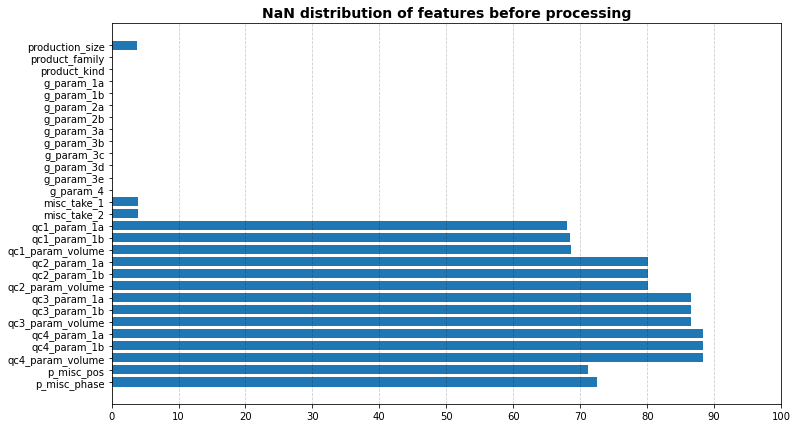

In [644]:
column_names = list(df_cleaned.isna().sum().index)
column_nan_count = list(df_cleaned.isna().sum())
column_lens = [len(df_cleaned)] * len(df_cleaned.columns)
column_nan_perc = [round((column_nan_count[idx]/column_lens[idx])*100,2)
                   for idx, col in enumerate(column_nan_count)]

df_nan_distribution = pd.DataFrame()
df_nan_distribution["Feature"] = column_names
df_nan_distribution["NaN %"] = column_nan_perc

y = column_names[::-1]
height = column_nan_perc[::-1]
plt.figure(figsize=(12,7))
plt.title("NaN distribution of features before processing", size=14, weight="bold")
plt.grid(ls="--", color="k", alpha=0.2, axis="x")
plt.barh(y, height)
plt.xticks(range(0,105,10))
plt.savefig("NaN_Dist_Features_b4_processing.png", bbox_inches="tight", dpi=300, transparent=True)
plt.show()

## Initial EDA pairplot

sns.pairplot(df_cleaned)

# PROCESSING DATA

## Show relationship between volume, qc_param_1a, qc_param_1b in different QCs

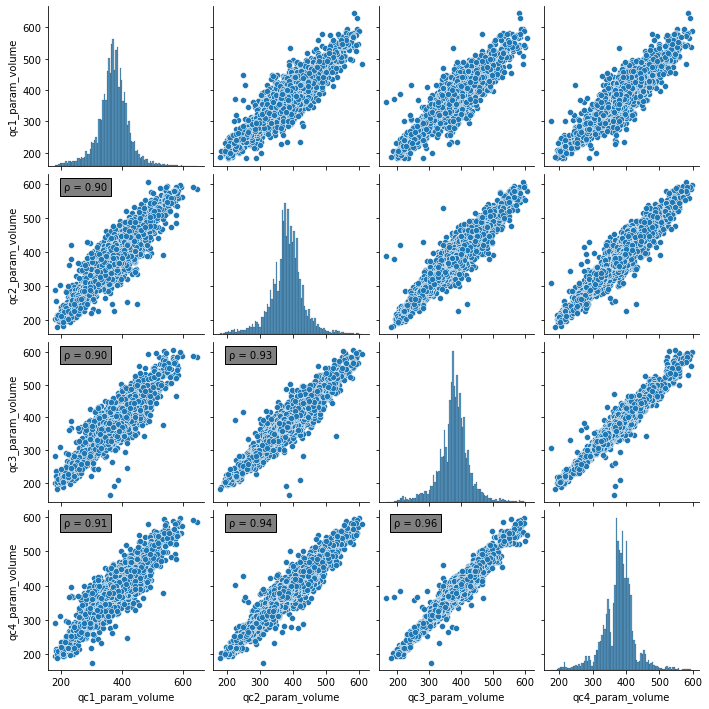

In [645]:
df_qc_vol_check = df_cleaned[["qc1_param_volume", "qc2_param_volume", "qc3_param_volume", "qc4_param_volume"]]
df_qc_vol_check = df_qc_vol_check[(df_qc_vol_check>150) & (df_qc_vol_check<700)]
df_qc_vol_check.dropna(axis=0, inplace=True)
df_qc_vol_check.reset_index(drop=True, inplace=True)

# CREATE PAIRPLOT TO SHOW CORRELATIONS OF DIFFERENT QC VOLUME STEPS
# DISPLAY CORRELATION (Pearson) IN RESPECTIVE PLOTS

def corrfunc(x, y, hue=None, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    r, _ = pearsonr(x, y)
    ax = ax or plt.gca()
    text = ax.annotate(f'ρ = {r:.2f}', xy=(.1, .9), xycoords=ax.transAxes)
    text.set_bbox(dict(facecolor='grey', edgecolor='k'))

p = sns.pairplot(df_qc_vol_check)
p.map_lower(corrfunc)
plt.show()

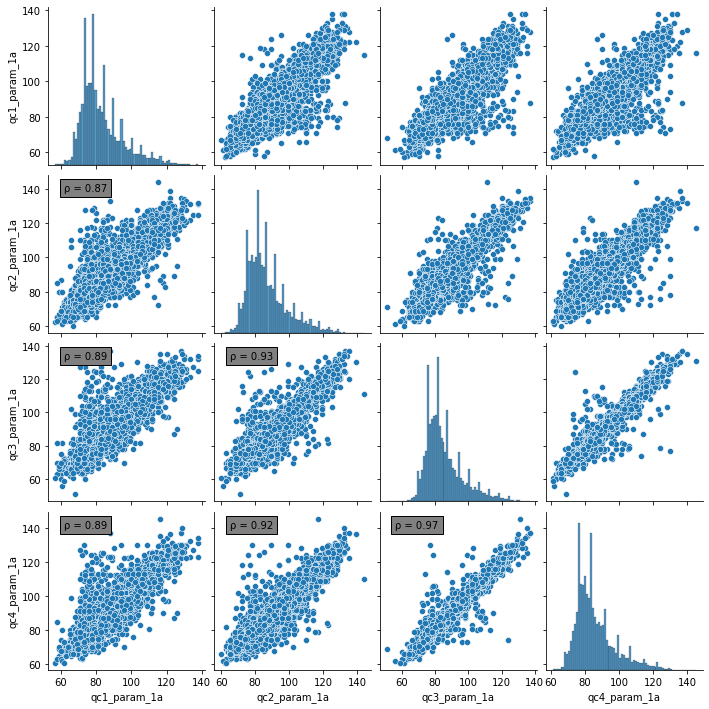

In [646]:
df_qc_vol_check = df_cleaned[["qc1_param_1a", "qc2_param_1a", "qc3_param_1a", "qc4_param_1a"]]
df_qc_vol_check = df_qc_vol_check[(df_qc_vol_check>50) & (df_qc_vol_check<170)]
df_qc_vol_check.dropna(axis=0, inplace=True)
df_qc_vol_check.reset_index(drop=True, inplace=True)

# CREATE PAIRPLOT TO SHOW CORRELATIONS OF DIFFERENT QC VOLUME STEPS
# DISPLAY CORRELATION (Pearson) IN RESPECTIVE PLOTS

def corrfunc(x, y, hue=None, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    r, _ = pearsonr(x, y)
    ax = ax or plt.gca()
    text = ax.annotate(f'ρ = {r:.2f}', xy=(.1, .9), xycoords=ax.transAxes)
    text.set_bbox(dict(facecolor='grey', edgecolor='k'))

p = sns.pairplot(df_qc_vol_check)
p.map_lower(corrfunc)
plt.show()

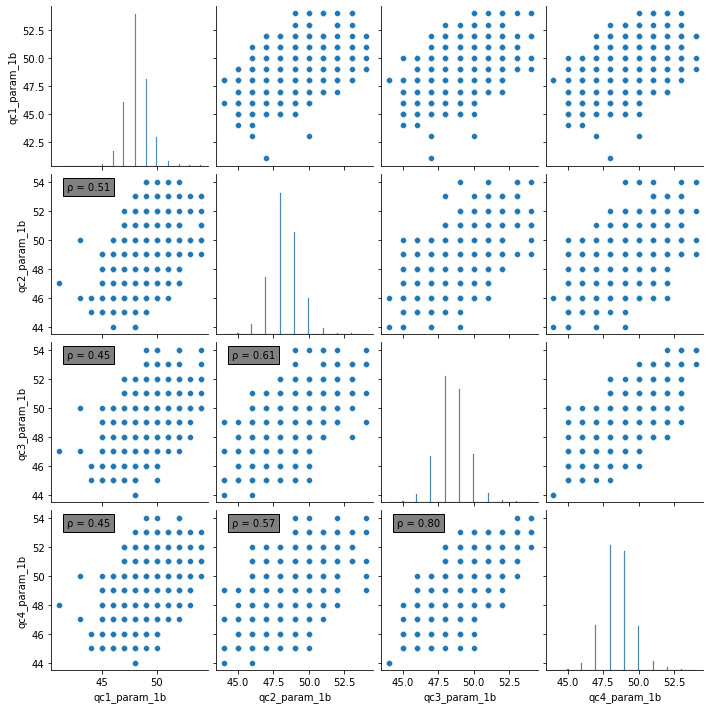

In [647]:
df_qc_vol_check = df_cleaned[["qc1_param_1b", "qc2_param_1b", "qc3_param_1b", "qc4_param_1b"]]
df_qc_vol_check = df_qc_vol_check[(df_qc_vol_check>40) & (df_qc_vol_check<55)]
df_qc_vol_check.dropna(axis=0, inplace=True)
df_qc_vol_check.reset_index(drop=True, inplace=True)

# CREATE PAIRPLOT TO SHOW CORRELATIONS OF DIFFERENT QC VOLUME STEPS
# DISPLAY CORRELATION (Pearson) IN RESPECTIVE PLOTS

def corrfunc(x, y, hue=None, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    r, _ = pearsonr(x, y)
    ax = ax or plt.gca()
    text = ax.annotate(f'ρ = {r:.2f}', xy=(.1, .9), xycoords=ax.transAxes)
    text.set_bbox(dict(facecolor='grey', edgecolor='k'))

p = sns.pairplot(df_qc_vol_check)
p.map_lower(corrfunc)
plt.show()

**`OBSERVATION / DESCRIPTION`**

- qc volume parameters are strongly correlated (>= 0.9)
- qc param 1a are strongly correlated (>= 0.87)
- qc param 1b are less strongly correlated (>= 0.45)
    - nature of param 1b values (whole numbers betwen ~ 40-55) makes them appear discrete
    - they will be used as numerical feature though

*Different qc parameters will be aggregated to condense features into single (target) feature!* <br>

Initial round of model creation aims at predicting qc volume. <br>
It is also planned to use geometric parameter + qc volume to predict param 1a and param 1b.

## Aggregating qc_volume, qc_param_1a, qc_param_1b in different QCs

In [648]:
# AVG ALL QC_VOLUMEs TO YIELD SINGLE TARGET FEATURE
qc1_vol = df_cleaned["qc1_param_volume"]
qc2_vol = df_cleaned["qc2_param_volume"]
qc3_vol = df_cleaned["qc3_param_volume"]
qc4_vol = df_cleaned["qc4_param_volume"]

# AVG ALL QC_VOLTAGEs
qc1_voltage = df_cleaned["qc1_param_1a"]
qc2_voltage = df_cleaned["qc2_param_1a"]
qc3_voltage = df_cleaned["qc3_param_1a"]
qc4_voltage = df_cleaned["qc4_param_1a"]

# AVG ALL QC_PULSEs
qc1_pulse = df_cleaned["qc1_param_1b"]
qc2_pulse = df_cleaned["qc2_param_1b"]
qc3_pulse = df_cleaned["qc3_param_1b"]
qc4_pulse = df_cleaned["qc4_param_1b"]

qc_volumes = list(zip(qc1_vol, qc2_vol, qc3_vol, qc4_vol))
qc_voltages = list(zip(qc1_voltage, qc2_voltage, qc3_voltage, qc4_voltage))
qc_pulses = list(zip(qc1_pulse, qc2_pulse, qc3_pulse, qc4_pulse))

qc_volume_means = [np.nanmean(volume) for volume in qc_volumes]
qc_voltage_means = [np.nanmean(voltage) for voltage in qc_voltages]
qc_puls_means = [np.nanmean(puls) for puls in qc_pulses]

# ADD NEW QC_MEAN COLUMNS TO DF
df_cleaned["qc_volume_mean"] = qc_volume_means
df_cleaned["qc_param_1a_mean"] = qc_voltage_means
df_cleaned["qc_param_1b_mean"] = qc_puls_means

# DROP SPECIFIC QC VOLUME, VOLTAGE, PULS COLUMNS & ONLY KEEP AVERAGED COLS
df_cleaned.drop(columns=["qc1_param_volume", "qc2_param_volume", "qc3_param_volume","qc4_param_volume",
                        "qc1_param_1a","qc2_param_1a","qc3_param_1a","qc4_param_1a",
                        "qc1_param_1b","qc2_param_1b","qc3_param_1b","qc4_param_1b"], inplace=True)

## Delete entries without target feature value

In [649]:
df_cleaned = df_cleaned[df_cleaned["qc_volume_mean"].notnull()].reset_index(drop=True)

## EDA / Pairplot after initial data processing

In [650]:
# GET NUMERICAL FEATURES FROM DATAFRAME
df_numerical_temp = df_cleaned.select_dtypes(include=np.number)

sns.pairplot(df_numerical_temp)

## Check NaN distribution in features post processing, but pre outlier / NaN trimming

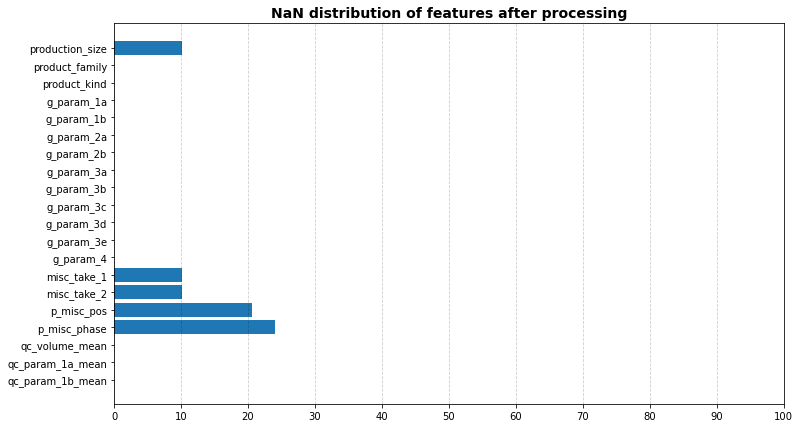

In [651]:
column_names = list(df_cleaned.isna().sum().index)
column_nan_count = list(df_cleaned.isna().sum())
column_lens = [len(df_cleaned)] * len(df_cleaned.columns)
column_nan_perc = [round((column_nan_count[idx]/column_lens[idx])*100,2)
                   for idx, col in enumerate(column_nan_count)]

df_nan_distribution = pd.DataFrame()
df_nan_distribution["Feature"] = column_names
df_nan_distribution["NaN %"] = column_nan_perc

y = column_names[::-1]
height = column_nan_perc[::-1]
plt.figure(figsize=(12,7))
plt.title("NaN distribution of features after processing", size=14, weight="bold")
plt.grid(ls="--", color="k", alpha=0.2, axis="x")
plt.barh(y, height)
plt.xticks(range(0,105,10))
plt.savefig("NaN_Dist_Features_post_processing_pre_interpolation.png", bbox_inches="tight", dpi=300, transparent=True)
plt.show()

## Dropping outliers / NaNs by trimming / pruning values to specific ranges
*Specific ranges are based on given production thresholds*

### Dropping outliers / NaNs by trimming - Geometric Parameters

In [652]:
# DROP ROWS WHERE VALUE IS BELOW/ABOVE CRITICAL, SENSIBLE THRESHOLD
print(len(df_cleaned))
df_cleaned = df_cleaned[(df_cleaned["g_param_2a"]>0) &
                       (df_cleaned["g_param_2a"]<=100)]
df_cleaned = df_cleaned[(df_cleaned["g_param_2b"]>0) &
                       (df_cleaned["g_param_2b"]<=90)]
df_cleaned = df_cleaned[(df_cleaned["g_param_3d"]>0) &
                       (df_cleaned["g_param_3d"]<=7)]
df_cleaned = df_cleaned[(df_cleaned["g_param_3e"]>=29) &
                       (df_cleaned["g_param_3e"]<=37)]
df_cleaned = df_cleaned[(df_cleaned["g_param_3a"]>=0) &
                       (df_cleaned["g_param_3a"]<=1.4)]
df_cleaned = df_cleaned[(df_cleaned["g_param_3b"]>0) &
                       (df_cleaned["g_param_3b"]<=1.2)]
df_cleaned = df_cleaned[(df_cleaned["g_param_3c"]>=0) &
                       (df_cleaned["g_param_3c"]<=4)]
df_cleaned = df_cleaned[(df_cleaned["g_param_4"]>=30) &
                       (df_cleaned["g_param_4"]<=70)]

32889


### Dropping outliers / NaNs by trimming - Functional Parameters

In [653]:
# DROP ROWS WHERE QC VOLUME, VOLTAGE, PULSE IS BELOW/ABOVE CRITICAL, SENSIBLE THRESHOLD
df_cleaned = df_cleaned[(df_cleaned["qc_volume_mean"]>=150) &
                       (df_cleaned["qc_volume_mean"]<=650)]
df_cleaned = df_cleaned[(df_cleaned["qc_param_1a_mean"]>=50) &
                       (df_cleaned["qc_param_1a_mean"]<=170)]
df_cleaned = df_cleaned[(df_cleaned["qc_param_1b_mean"]>=40) &
                       (df_cleaned["qc_param_1b_mean"]<=55)]

df_cleaned.reset_index(drop=True, inplace=True)
print(len(df_cleaned))

27010


## Check NaN distribution in all features after processing and outlier / NaN trimming

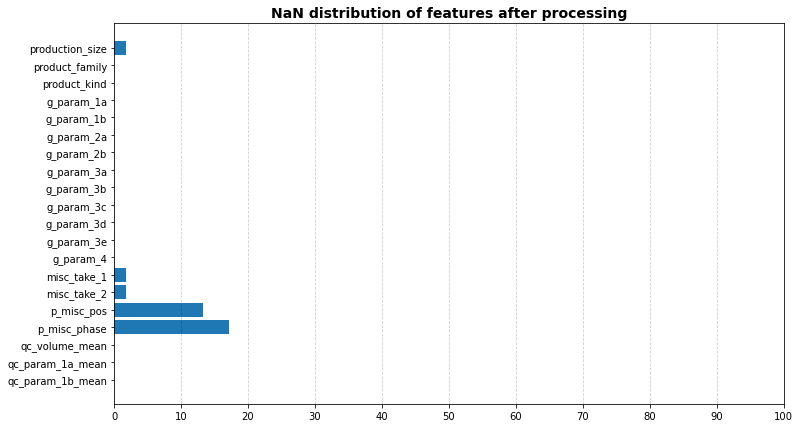

In [654]:
column_names = list(df_cleaned.isna().sum().index)
column_nan_count = list(df_cleaned.isna().sum())
column_lens = [len(df_cleaned)] * len(df_cleaned.columns)
column_nan_perc = [round((column_nan_count[idx]/column_lens[idx])*100,2)
                   for idx, col in enumerate(column_nan_count)]

df_nan_distribution = pd.DataFrame()
df_nan_distribution["Feature"] = column_names
df_nan_distribution["NaN %"] = column_nan_perc

y = column_names[::-1]
height = column_nan_perc[::-1]
plt.figure(figsize=(12,7))
plt.title("NaN distribution of features after processing", size=14, weight="bold")
plt.grid(ls="--", color="k", alpha=0.2, axis="x")
plt.barh(y, height)
plt.xticks(range(0,105,10))
plt.savefig("NaN_Dist_Features_post_processing_post_interpolation.png", bbox_inches="tight", dpi=300, transparent=True)
plt.show()

## Splitting numerical and categorical data

In [655]:
# GET NUMERICAL FEATURES FROM DATAFRAME
df_numerical = df_cleaned.select_dtypes(include=np.number)

# DROP CATEGORICAL FEATURES FROM NUMERICAL DATAFRAME
df_numerical.drop(columns=["production_size", "product_kind", "product_family",
                          "misc_take_1","misc_take_2", "p_misc_pos"], inplace=True)

# TAKE CATEGORICAL FEATURES FROM DATAFRAME
df_categorical = df_cleaned[["product_kind", "production_size", 
                             "misc_take_1","misc_take_2", "p_misc_pos"]]

## Processing NaN values - Categoricals

### Fill NaN misc_take_1 with average of non-zero entries
*min = 0; max = 5 --> based on procedural limits*

In [656]:
df_categorical["misc_take_1"].fillna(int(np.mean(
    [int(k1e) for k1e in list(df_categorical["misc_take_1"].unique()) if 6 > k1e > 0])), inplace=True)

### Fill NaN misc_take_2 with average of non-zero entries
*min = 0; max = 6 --> based on procedural limits*

In [657]:
df_categorical["misc_take_2"].fillna(
    int(np.mean([int(k1e) for k1e in list(df_categorical["misc_take_2"].unique()) if 7 > k1e > 0])), inplace=True)

### Fill NaN p_misc_pos with median

In [658]:
df_categorical["p_misc_pos"].fillna(df_categorical["p_misc_pos"].median(), inplace=True)

### Fill NaN production_size with median

In [659]:
df_categorical["production_size"].fillna(df_categorical["production_size"].median(), inplace=True)

### Check NaN distribution in categorical features after processing and outlier / NaN trimming

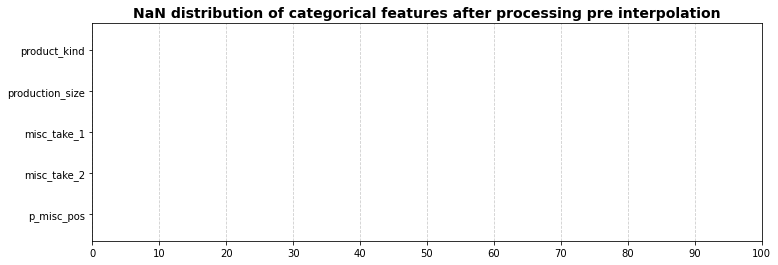

In [660]:
column_names = list(df_categorical.isna().sum().index)
column_nan_count = list(df_categorical.isna().sum())
column_lens = [len(df_categorical)] * len(df_categorical.columns)
column_nan_perc = [round((column_nan_count[idx]/column_lens[idx])*100,2)
                   for idx, col in enumerate(column_nan_count)]

df_nan_distribution = pd.DataFrame()
df_nan_distribution["Feature"] = column_names
df_nan_distribution["NaN %"] = column_nan_perc

y = column_names[::-1]
height = column_nan_perc[::-1]
plt.figure(figsize=(12,4))
plt.title("NaN distribution of categorical features after processing pre interpolation", size=14, weight="bold")
plt.grid(ls="--", color="k", alpha=0.2, axis="x")
plt.barh(y, height)
plt.xticks(range(0,105,10))
#plt.savefig("NaN_Dist_Cat-Features_post_processing_pre_interpolation.png", bbox_inches="tight", dpi=300, transparent=True)
plt.show()

## Check multicollinearity for numerical features

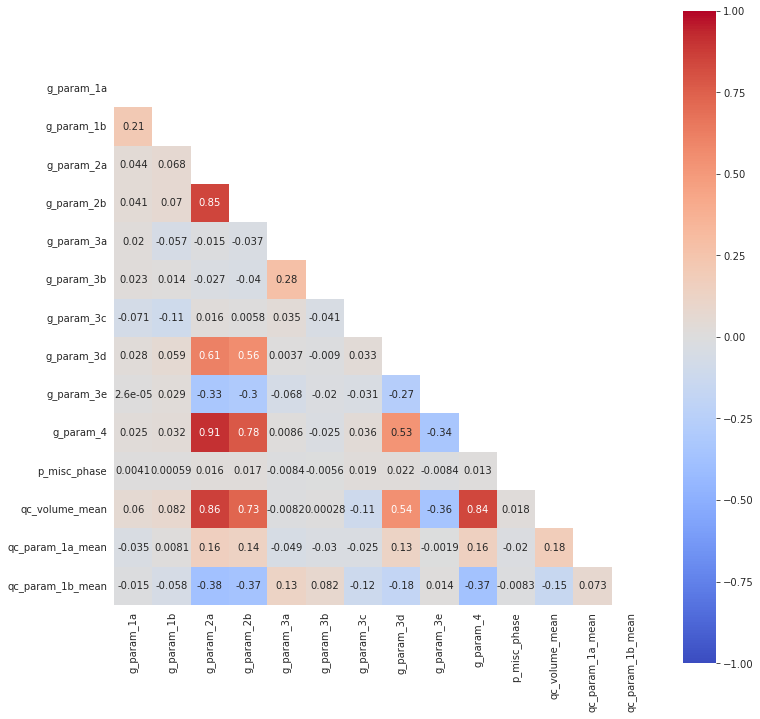

In [661]:
corr = df_numerical.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(12, 12))
    ax = sns.heatmap(corr, mask=mask,cmap='coolwarm', vmin=-1,vmax=1,annot=True, square=True)

In [662]:
def show_and_drop_high_correlation_features(df, threshold):
    """
    Show any features that have correlation higher than threshold with any other;
    """
    corr_matrix=df.corr().abs()
    upper_triangle=corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(bool))
    
    cols_above_threshold = [column for column in upper_triangle.columns if any(upper_triangle[column] > threshold)]
    cols_above_threshold = [col for col in cols_above_threshold if "vol" not in col]
    #cols_above_threshold = ["g_param_2a", "g_param_4"]
    df = df.drop(columns=cols_above_threshold)
    return df

df_numerical = show_and_drop_high_correlation_features(df_numerical, 0.8)

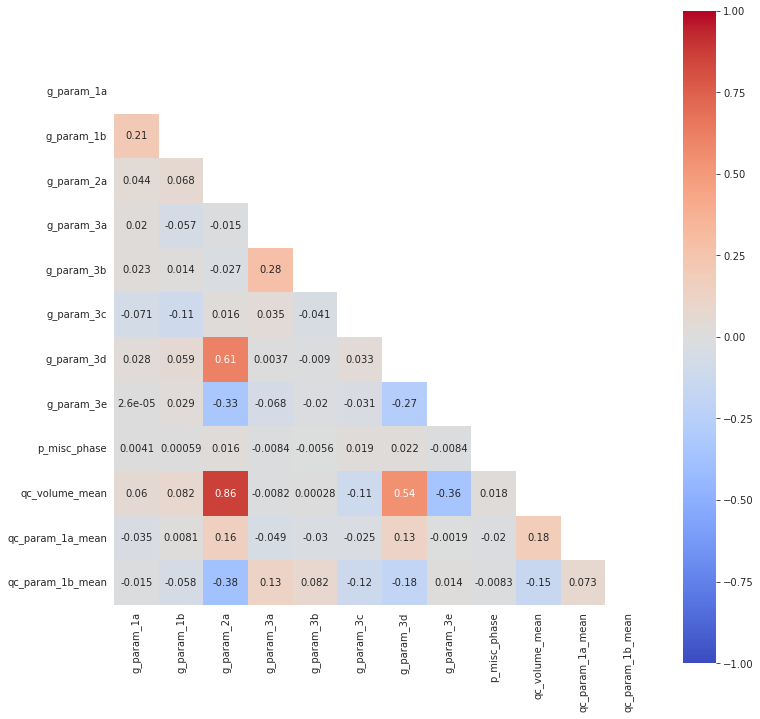

In [663]:
corr_matrix = df_numerical.corr()
corr = df_numerical.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(12, 12))
    ax = sns.heatmap(corr, mask=mask,cmap='coolwarm', vmin=-1,vmax=1,annot=True, square=True)

## Hot-Encode categorical features

In [664]:
df_categorical_hotcoded = pd.get_dummies(df_categorical, drop_first=True)

# Linear Regression

## Select data to be used

### NUMERICAL ONLY

df_to_use = df_numerical

### NUMERICAL + CATEGORICAL

In [665]:
df_to_use = pd.concat([df_numerical, df_categorical], axis=1)

In [666]:
df_to_use

,g_param_1a,g_param_1b,g_param_2a,g_param_3a,g_param_3b,g_param_3c,g_param_3d,g_param_3e,p_misc_phase,qc_volume_mean,qc_param_1a_mean,qc_param_1b_mean,product_kind,production_size,misc_take_1,misc_take_2,p_misc_pos
0,18.00,53.00,68.30,0.00,0.18,1.40,6.00,31.60,NaN,412.00,72.00,49.00,1,1.00,0.00,0.00,0.00
1,10.00,11.00,68.80,0.56,0.21,1.30,5.96,32.80,NaN,417.00,82.00,48.00,1,1.00,0.00,0.00,0.00
2,28.00,61.00,67.60,0.73,0.94,1.40,5.81,32.10,NaN,392.00,71.00,48.00,1,1.00,0.00,0.00,0.00
3,8.00,29.00,72.40,1.16,0.69,1.30,5.96,33.20,NaN,427.00,78.00,48.00,1,1.00,0.00,0.00,0.00
4,3.00,59.00,71.60,1.07,0.86,1.30,5.62,33.80,NaN,404.00,74.00,48.00,1,1.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27005,10.50,32.30,48.13,0.01,0.62,1.60,5.08,36.60,NaN,221.00,84.00,47.00,1,5.00,3.00,3.00,0.00
27006,30.70,7.70,46.30,0.01,0.77,1.80,4.71,36.00,NaN,202.00,64.00,45.00,1,5.00,3.00,3.00,0.00
27007,33.50,20.10,45.70,0.03,0.50,2.00,4.62,36.00,NaN,214.00,70.00,47.00,1,5.00,3.00,3.00,0.00
27008,1.40,19.30,73.22,0.43,0.17,1.10,5.84,30.20,NaN,401.00,97.00,49.00,1,6.00,3.00,5.00,0.00


In [667]:
print("Rows before dropping NaN values: ", len(df_to_use))
df_to_use = df_to_use.dropna(axis=0)
print("Rows after dropping NaN values: ", len(df_to_use))

Rows before dropping NaN values:  27010
Rows after dropping NaN values:  22364


sns.pairplot(df_to_use)
fig.savefig("Pairplot_df_numerical_cleaned.jpg", bbox_inches="tight", dpi=300)

## X-y Split

In [668]:
#X = df_to_use.drop('qc_volume_mean', axis=1)
X = df_to_use.drop(['qc_volume_mean', 
                    'qc_param_1a_mean', 'qc_param_1b_mean'], axis=1) #, 'qc_voltage_mean', 'qc_puls_mean'
y = df_to_use["qc_volume_mean"]

## Train - Test - Split

In [669]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.3,random_state=42)

print("Shape X_train:", X_train.shape)
print("Shape X_test:", X_test.shape)
print("Shape y_train:", y_train.shape)
print("Shape y_test:", y_test.shape)

Shape X_train: (15654, 14)
Shape X_test: (6710, 14)
Shape y_train: (15654,)
Shape y_test: (6710,)


## Standardize the data after data split

In [670]:
# Standardize training data
std_scaler = StandardScaler().fit(X_train) # get mean, variance from training set

# Scale training data
X_train_scaled = std_scaler.transform(X_train)

# Scale test data with mean, variance from training data
X_test_scaled = std_scaler.transform(X_test)

print(X_train_scaled.shape, X_test_scaled.shape)

model=LinearRegression()             # model
model.fit(X_train_scaled, y_train)   # model train

print("Coefficients (betas): ", np.around(model.coef_,4))
print("Coefficients (alpha): ", np.around(model.intercept_,4))

y_pred=model.predict(X_test_scaled)   # model prediction
y_pred_train=model.predict(X_train_scaled)

(15654, 14) (6710, 14)
Coefficients (betas):  [ 0.6259  1.3494 40.4736 -1.4405  0.5326 -6.5217 -1.1572 -2.1177  0.3179
  0.411   6.5256  0.2838  0.2838  1.6729]
Coefficients (alpha):  377.2124


qc_volume_mean = 0.8808 * g_param_1a + 1.457 * g_param_1b + 43.9014 * g_param_2a - 0.3277 * g_param_3a + 1.2356 * g_param_3b + 0.5926 * g_param_3d + -4.4631 * g_param_3e + 375.7451

## Evaluating Model Performance

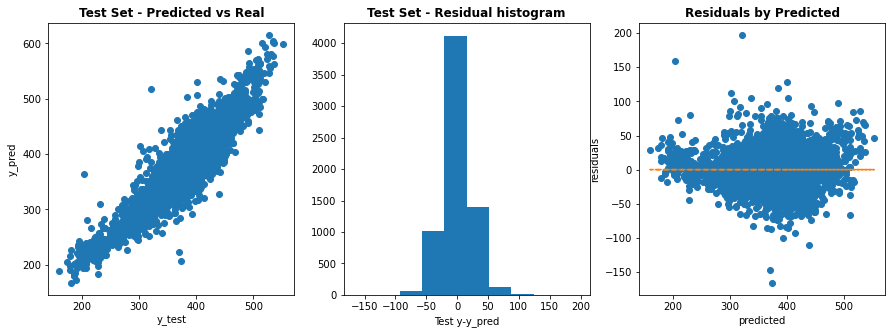

In [671]:
result=pd.DataFrame({"y_test":y_test,"y_pred":y_pred})

# Make an scatter plot y_pred vs y
# What kind of plot you will get if all the all the predictions are ok?
# A stright line

fig, ax = plt.subplots(1,3,figsize=(15,5))
ax[0].plot(y_pred, y_test, 'o')
ax[0].set_xlabel("y_test")
ax[0].set_ylabel("y_pred")
ax[0].set_title("Test Set - Predicted vs Real", weight="bold")

# Get a histogram of the residuals ie: y - y_pred.  
# It resembles a normal distribution?
ax[1].hist(y_test - y_pred)
ax[1].set_xlabel("Test y-y_pred")
ax[1].set_title("Test Set - Residual histogram", weight="bold")

# Homoscdasticity
# Check if residuals are somewhat uniformally distributed around null-line
ax[2].plot(y_pred,y_test - y_pred,"o")
ax[2].set_xlabel("predicted")
ax[2].set_ylabel("residuals")
ax[2].set_title("Residuals by Predicted", weight="bold")
ax[2].plot(y_pred,np.zeros(len(y_pred)),linestyle='dashed')
plt.show()

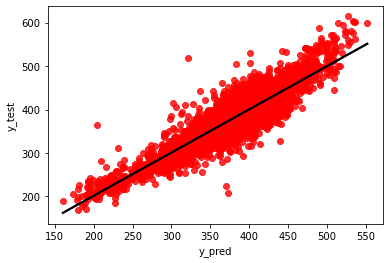

In [672]:
sns.regplot(x='y_pred',y='y_test', data=result, scatter_kws={"color": "red"}, line_kws={"color": "black"})
plt.show()

## Error metrics

In [673]:
mse_1 = round(mse(y_test,y_pred),2)
rmse_1 = round(np.sqrt(mse(y_test,y_pred)),2)
mae_1 = round(mae(y_test,y_pred),2)

print("MSE:", mse_1) # shows squared error (harder to interpret)
print("RMSE:", rmse_1) # shows error
print("MAE:", mae_1) # shows real error (in $)
print("-----")

# R^2
R2_1 = round(r2_score(y_test,y_pred),2)

# Adj. R^2
Adj_R2_1 = round(1 - (1-R2_1)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1),2) # X_test.shape[1] == len(X_test.columns)

print(f"R^2 for <numerical (with outliers) only> is {round(R2_1,2)}.")
print(f"Adjusted R^2 for <numerical (with outliers) only> is {round(Adj_R2_1,2)}.")

MSE: 538.54
RMSE: 23.21
MAE: 17.53
-----
R^2 for <numerical (with outliers) only> is 0.8.
Adjusted R^2 for <numerical (with outliers) only> is 0.8.


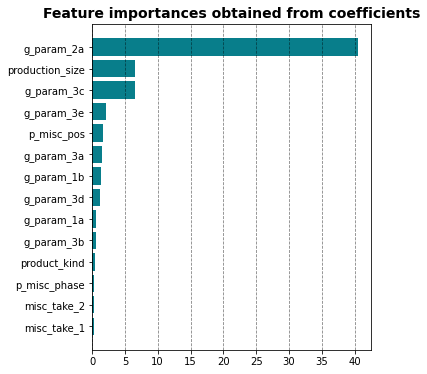

In [723]:
features_importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': abs(model.coef_)})

features_importances = features_importances.sort_values(by='Importance', ascending=False)
width = features_importances['Importance'][::-1]
y = features_importances['Attribute'][::-1]

fig = plt.figure(figsize=(5,6))
plt.grid(ls="--", alpha=0.5, color="k", axis="x")
plt.barh(y=y, width=width, color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=14, weight="bold")
plt.xticks(list(range(0,int(max(width)+5),5)))
plt.savefig("Feature_Importance_1.jpg", bbox_inches="tight", dpi=300)
plt.show()

**`OBSERVATIONS`**
- When not filtering on ns2_cv and ns2_fa, R2 increases from 0.72 to 0.82
- Changing random seed has significant impact (~ +/- 0.05) on R2


- not filtering on ns2_cv / ns2_fa / ns2_curve + seed = 6969 --> R2 = 0.8
- not filtering on ns2_cv / ns2_fa / ns2_curve + seed = 42 --> R2 = 0.79
- not filterin ns2_curve + seed 6969 --> R2 = 0.78
- filtering on all + seed 6969 --> R2 = 0.76
- not filtering on qc_voltages / qc_pulses + seed 6969 --> R2 = 0.55


# Lasso Regression

# Model Evaluation

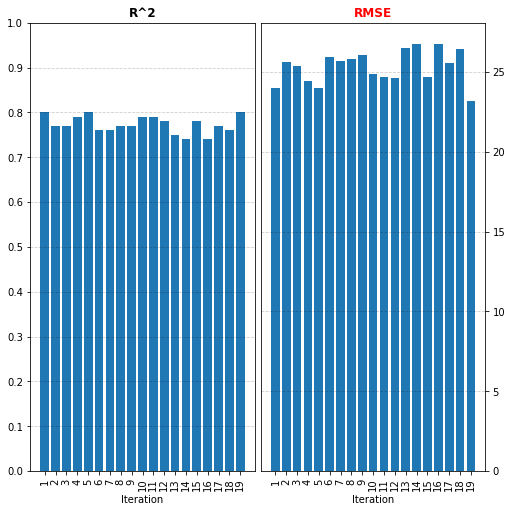

In [739]:
Iterations = list(range(1,20))

R2 = [0.80, 0.77, 0.77, 0.79, 0.80, 0.76, 0.76, 0.77, 0.77, 0.79, 
0.79, 0.78, 0.75, 0.74, 0.78, 0.74, 0.77, 0.76, 0.80]

adj_R2 = [0.80, 0.77, 0.77, 0.79, 0.80, 0.76, 0.76, 0.77, 0.77, 0.79, 
0.79, 0.78, 0.75, 0.74, 0.78, 0.74, 0.77, 0.76, 0.80]

MSE = [576.87, 656.47, 642.54, 598.18, 576.21, 671.56, 658.91, 
       664.91, 679.62, 618.20, 608.99, 604.44, 702.92, 715.1, 
       608.75, 715.1, 653.86, 698.37, 538.54]

RMSE = [24.02, 25.62, 25.35, 24.46, 24.00, 25.91, 25.67, 25.79, 
        26.07, 24.86, 24.68, 24.59, 26.51, 26.74, 24.67, 26.74, 
        25.57, 26.43, 23.21]

MAE = [17.84, 19.30, 19.13, 18.13, 17.96, 19.27, 19.20, 19.45, 
       19.55, 18.88, 18.74, 18.4, 20.03, 20.13, 18.41, 20.13, 
       19.4, 20.27, 17.53]

fig, ax = plt.subplots(1, 2, figsize=(7,7), constrained_layout = True)
#fig.suptitle("Evaluation of different model iterations", size=14, weight="bold")

ax[0].bar(Iterations, R2)
ax[0].set_title('R^2', size=12, weight="bold")
ax[0].set_yticks(np.arange(0,1.01,0.1))
ax[0].grid(ls="--", color="k", alpha=0.2, axis="y")
ax[0].set_xticks(list(range(1,20)))
for tick in ax[0].get_xticklabels():
    tick.set_rotation(90)
ax[0].set_xlabel("Iteration")

#ax[1].bar(Iterations, MSE)
#ax[1].set_title('MSE', size=12, weight="bold")

ax[1].bar(Iterations, RMSE)
ax[1].set_title('RMSE - ', size=12, weight="bold", color='red')
ax[1].yaxis.set_label_position("right")
ax[1].yaxis.tick_right()
ax[1].grid(ls="--", color="k", alpha=0.2, axis="y")
ax[1].set_xticks(list(range(1,20)))
for tick in ax[1].get_xticklabels():
    tick.set_rotation(90)
ax[1].set_xlabel("Iteration")

#ax[3].bar(Iterations, MAE)
#ax[3].set_title('MAE', size=12, weight="bold")
#ax[3].yaxis.set_label_position("right")
#ax[3].yaxis.tick_right()

plt.savefig("R2_RMSE_Evaluation.jpg", bbox_inches="tight", dpi=300)

plt.show()